# Multiobjective optimisation

Often, you have more than one objective. A typical example would be a production process where we both want to lower the price and increase the quality of the product.

One approach is to construct a artificial objective function that takes all relevant objectives. However, this is often complicated, if not impossible, to do, especially since you need to do it before you have any data.

Instead, you can do optimisation on all objectives at once. This transforms what the `ProcessOptimizer` aims at, since it no longer makes sense to find the point in control parameter space with the best objective. Instead, `ProcessOptimizer` aims to find points that can not be improved upon without some sacrifice. More stringently, these are points where no other point is as good or better on all objectives, so if you want to improve one objective, you have to accept some other objective becoming worse. Such points are said to be Pareto optimal (do we prefer Pareto optimal or Pareto efficient?), and the set of all Pareto optimal points is called the Pareto front.

When `ProcessOptimizer` has more than one objective, the first `n_initial_points` experiemnts are still found using Latin Hypercube Sampling. Further experiments are suggested using either Steinerberger sampling or estimating the Pareto front and selecting a point on it.

## Steinerberger sampling
Steinerberger sampling 

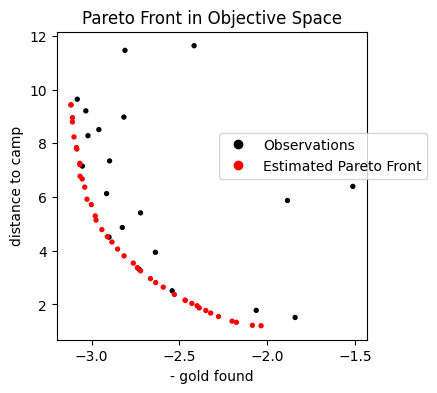

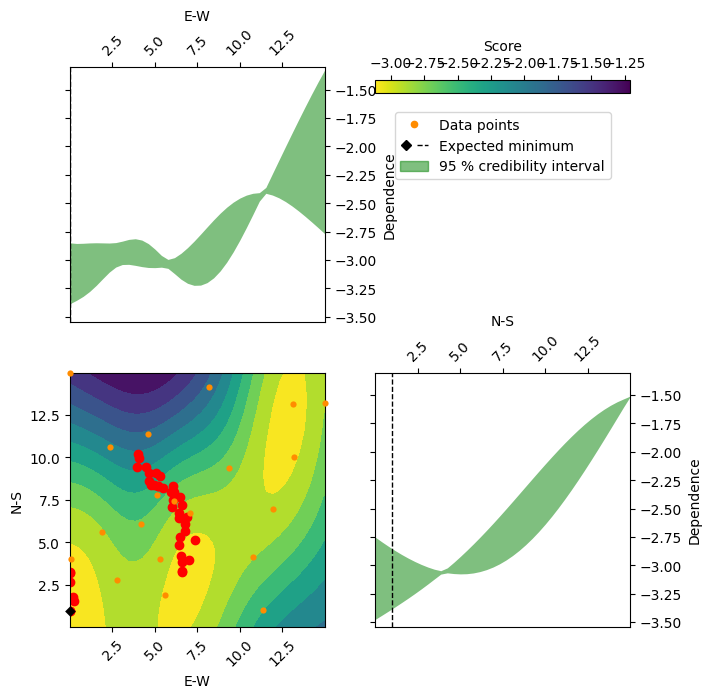

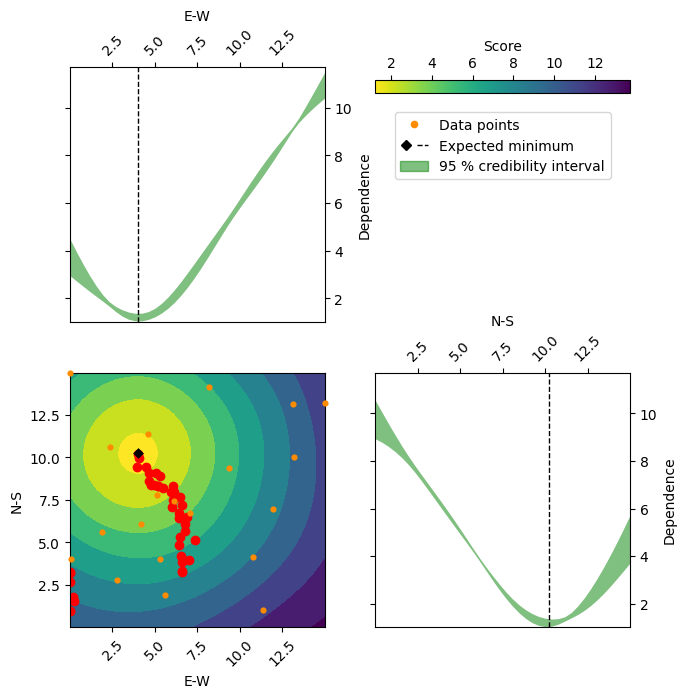

In [6]:
import ProcessOptimizer as po
from ProcessOptimizer.model_systems import get_model_system
from ProcessOptimizer import Optimizer

# Define the model system
gold_model_system = get_model_system("gold_map")
distance_model_system = get_model_system("distance_map")

space = distance_model_system.space

opt = Optimizer(space, n_initial_points=4, n_objectives=2)

for i in range(20):
    new_dig_site = opt.ask()
    gold_found = gold_model_system.get_score(new_dig_site)
    distance = distance_model_system.get_score(new_dig_site)
    result = opt.tell(new_dig_site, [gold_found, distance])

front = po.plot_Pareto(optimizer=opt, figsize = [4,4], objective_names=["- gold found", "distance to camp"], return_data=True)
figure_list = []
for n in range(len(result)):
    figure_list.append(po.plot_objective(
        result = result[n],
        pars = "expected_minimum",
        dimensions= ["E-W", "N-S"],
    ))
    for point in front[2]:
        figure_list[n][1][0].scatter(x=[point[0]], y=[point[1]], c="red")


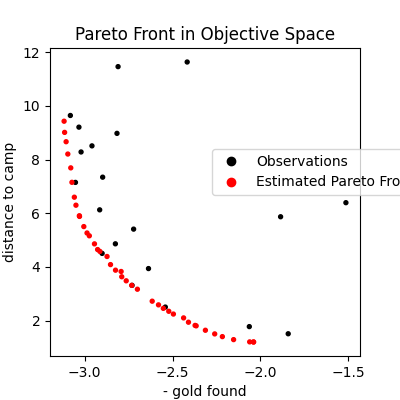

In [10]:
#ipympl is needed for the following cell to render. without ipympl, the user is still able to run po.plot_pareto(optimizer) but the plot will not be interactive.
%matplotlib widget
po.plot_Pareto(
    optimizer=opt,
    figsize = [4,4],
    objective_names=["- gold found", "distance to camp"],
    dimensions= ["E-W", "N-S"],
)